In [1]:
import os
import numpy as np

import matplotlib.pyplot as plt
import colorcet as cc
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()

from utils import *

## Load data

In [2]:
folder_indoor = 'data/indoor'

info_indoor = load_info(folder_indoor)
user_info_indoor = load_user_info(folder_indoor, info_indoor)
gaze_indoor = load_gaze(folder_indoor, info_indoor)
odometry_indoor = load_odometry(folder_indoor, info_indoor)

In [3]:
folder_outdoor = 'data/outdoor'

info_outdoor = load_info(folder_outdoor)
user_info_outdoor = load_user_info(folder_outdoor, info_outdoor)
gaze_outdoor = load_gaze(folder_outdoor, info_outdoor)
odometry_outdoor = load_odometry(folder_outdoor, info_outdoor)

In [4]:
user_info = {**user_info_indoor, **user_info_outdoor}
gaze = xr.concat([gaze_indoor, gaze_outdoor], dim='time')
odometry = xr.concat([odometry_indoor, odometry_outdoor], dim='time')
_, r_realsense_pupil = load_extrinsics('data')

## Analysis

### Reference frame transformations

In [5]:
r_pupil_eyes = shortest_arc_rotation(
    gaze.gaze_point, np.array([0., 0., 1.])[None, :])

In [6]:
r_world_head = stack_rotations(
    odometry.orientation.values,
    r_realsense_pupil,
    r_pupil_anatomic)

r_world_eyes = stack_rotations(
    odometry.orientation,
    r_realsense_pupil,
    r_pupil_eyes.interp(time=odometry.time),
    r_pupil_anatomic)

In [7]:
linear_velocity_head = odometry.linear_velocity \
    .pipe(rotate_vectors, r_world_head, inverse=True)

angular_velocity_head = odometry.angular_velocity \
    .pipe(rotate_vectors, r_world_head, inverse=True)

linear_velocity_head_spherical = linear_velocity_head \
    .pipe(cartesian_to_spherical) \
    .pipe(center_spherical_coordinates) \
    .pipe(radians_to_degrees)

linear_velocity_eyes_spherical = odometry.linear_velocity \
    .pipe(rotate_vectors, r_world_eyes, inverse=True) \
    .pipe(cartesian_to_spherical) \
    .pipe(center_spherical_coordinates) \
    .pipe(radians_to_degrees)

gaze_point_spherical = gaze.gaze_point \
    .pipe(rotate_vectors, r_pupil_anatomic, inverse=True) \
    .pipe(cartesian_to_spherical) \
    .pipe(center_spherical_coordinates) \
    .pipe(radians_to_degrees)

### Data exclusion

In [8]:
min_gaze_confidence = 0.8
min_tracker_confidence = 3
window_len = 100
max_eye_velocity = 750

#### Gaze data

Smooth gaze point and norm pos with boxcar filter

In [9]:
gaze_point_smoothed = gaze_point_spherical \
    .pipe(smooth, window_len=window_len)

Compute gaze velocity

In [10]:
gaze_vel_smoothed = gaze_point_smoothed \
    .differentiate('time', datetime_unit='s') \
    .rename('gaze_velocity')

gaze_vel_norm = gaze_vel_smoothed \
    .sel(spherical_axis=['theta', 'phi']) \
    .reduce(np.linalg.norm, dim='spherical_axis')

Clean gaze point and velocity

In [11]:
gaze_point_clean = gaze_point_smoothed \
    .pipe(clean,
          gaze.gaze_confidence > min_gaze_confidence,
          gaze_vel_norm < max_eye_velocity)

gaze_vel_clean = gaze_vel_smoothed \
    .pipe(clean,
          gaze.gaze_confidence > min_gaze_confidence,
          gaze_vel_norm < max_eye_velocity)

#### Head tracking data

In [12]:
linear_velocity_head = linear_velocity_head \
    .pipe(clean, odometry.tracker_confidence >= min_tracker_confidence)

angular_velocity_head = angular_velocity_head \
    .pipe(clean, odometry.tracker_confidence >= min_tracker_confidence)

linear_velocity_head_spherical = linear_velocity_head_spherical \
    .pipe(clean, odometry.tracker_confidence >= min_tracker_confidence)

linear_velocity_eyes_spherical = linear_velocity_eyes_spherical \
    .pipe(clean, odometry.tracker_confidence >= min_tracker_confidence)

### Vestibulo-ocular reflex

In [13]:
d1 = float(user_info['tvor_close_distance'])
d2 = float(user_info['tvor_far_distance'])

conditions = {
    'rvor_yaw': 
        ('z', 'phi', -angular_velocity_head/np.pi*180),
    'rvor_pitch': 
        ('y', 'theta', -angular_velocity_head/np.pi*180),
    'tvor_close': 
        ('z', 'theta', np.arctan(linear_velocity_head/d1)/np.pi*180),
    'tvor_far':  
        ('z', 'theta', np.arctan(linear_velocity_head/d2)/np.pi*180),
}

v_eyes = {
    condition: gaze_vel_clean.sel(
        time=slice(user_info[f'{condition}_start'], 
                   user_info[f'{condition}_end']),
        spherical_axis=s_axis)
    for condition, (_, s_axis, _) in conditions.items()
}

v_head = {
    condition: head_vel.sel(
        time=slice(user_info[f'{condition}_start'], 
                   user_info[f'{condition}_end']),
        cartesian_axis=c_axis)
    for condition, (c_axis, _, head_vel) in conditions.items()
}

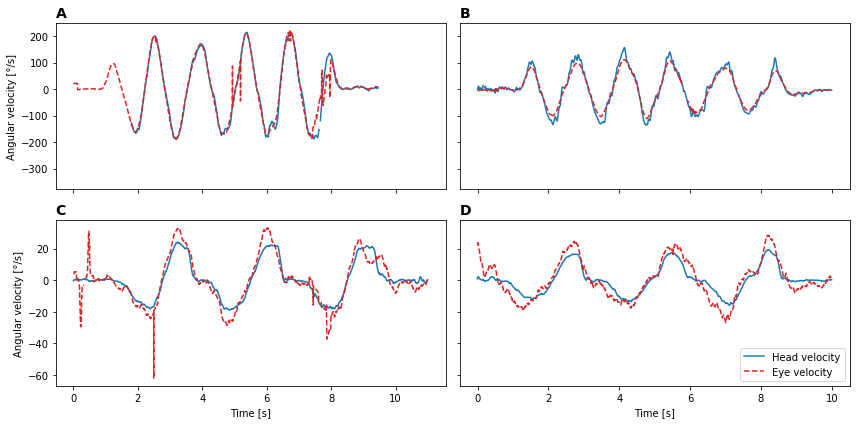

In [14]:
fig, axarr = plt.subplots(2, 2, sharex='col', sharey='row', figsize=(12, 6))
axarr = axarr.flatten()

for idx, condition in enumerate(conditions):
    
    axarr[idx].plot(
        (v_head[condition].time - v_head[condition].time[0]).astype(float)/1e9, 
        v_head[condition], color='tab:blue', label='Head velocity')
    
    axarr[idx].plot(
        (v_eyes[condition].time - v_eyes[condition].time[0]).astype(float)/1e9, 
        v_eyes[condition], color='tab:red', linestyle='dashed', label='Eye velocity')
    
    axarr[idx].set_title(
        chr(ord('A') + idx), loc='left', fontweight='bold', fontsize=14)
    
    if idx >= 2:
        axarr[idx].set_xlabel('Time [s]')
    if idx % 2 == 0:
        axarr[idx].set_ylabel('Angular velocity [°/s]')
    if idx == 3:
        axarr[idx].legend(loc='lower right')
        
fig.tight_layout()

In [15]:
fig.savefig('results/vor.png', dpi=300, bbox_inches='tight')

### Heatmaps

In [16]:
max_angle = 45
nbins = 100

In [17]:
walk_times = slice(user_info['walk_start'], user_info['walk_end'])

def compute_2d_histogram(
        data, dim, ix, iy, times, nbins=nbins, 
        xrange=(-max_angle, max_angle), yrange=(-max_angle, max_angle)):
    """ Compute 2D histogram from DataArray. """
    return histogram2d(
        data.sel(**{dim: ix, 'time': times}), 
        data.sel(**{dim: iy, 'time': times}), 
        range=[xrange, yrange], bins=nbins).T

heatmaps = {
    'v_lin':  compute_2d_histogram(
        linear_velocity_head_spherical, 'spherical_axis', 'phi', 'theta', walk_times),
    'p_gaze': compute_2d_histogram(
        gaze_point_spherical, 'spherical_axis', 'phi', 'theta', walk_times),
    'v_lin_eyes': compute_2d_histogram(
        linear_velocity_eyes_spherical, 'spherical_axis', 'phi', 'theta', walk_times),
}

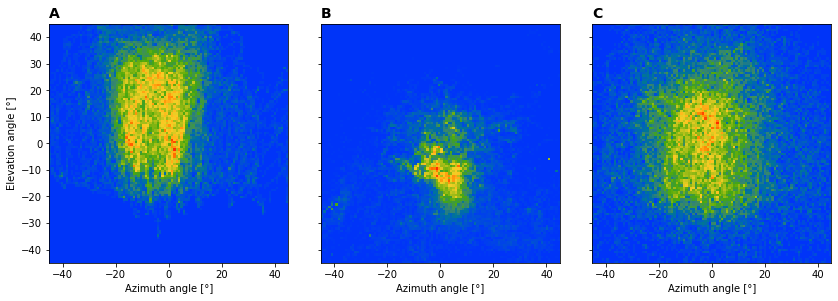

In [18]:
fig, axarr = plt.subplots(
    ncols=3, figsize=(12, 4), sharey=True)

for idx, heatmap in enumerate(heatmaps.values()):

    axarr[idx].imshow(heatmap, cmap=cc.cm.rainbow, 
                      extent=[-max_angle, max_angle, -max_angle, max_angle])
    
    axarr[idx].set_title(
        chr(ord('A') + idx), loc='left', fontweight='bold', fontsize=14)
    
    axarr[idx].set_xlabel('Azimuth angle [°]')
    if idx == 0:
        axarr[idx].set_ylabel('Elevation angle [°]')

fig.tight_layout()

In [19]:
fig.savefig('results/heatmaps.png', dpi=300, bbox_inches='tight');

Fin